<a href="https://colab.research.google.com/github/sameersundrani/CS229_FinalProject_Nigeria/blob/main/Maternal_Mortality_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS229 Final Project: Predicting Regional Maternal Mortality Risk in Nigeria
### Sameer Sundrani (sundrani), Amy Zhang (ayzhang), Cora Wendlandt (coraw)


In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import precision_score, confusion_matrix, roc_auc_score, accuracy_score, balanced_accuracy_score,recall_score, precision_recall_curve, roc_curve, f1_score, auc, fbeta_score, make_scorer, classification_report
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from matplotlib import pyplot
from google.colab import drive
import xgboost
# !pip install shap
# import shap 
from xgboost import XGBClassifier

## Data Loading
The below code will mount to your Google Drive account so you will have access to the files in your Drive. It will bring you to a seperate authentication page and you will have to copy and paste a code in order to get access. Just follow the instructions!

In [6]:
drive.mount('/content/drive', force_remount=True)

# add your own path string based on where you stored our shared project folder in your Google Drive
FOLDERNAME_AMY = '/content/drive/MyDrive/CS229_Final_Project_Shared'
#FOLDERNAME_CORA = 
#FOLDERNAME_SAMEER = 

#CHANGE THIS TO BE YOUR PATHNAME WHEN RUNNING ON YOUR DRIVE ACCOUNT
FOLDERNAME = FOLDERNAME_AMY

all_data = pd.read_csv(FOLDERNAME + "/all_data.csv")
all_data.head()

Mounted at /content/drive


,Unnamed: 0,CASEID,region,dv_weight,place,age,numSons,numDaughters,numSonsDied,numDaughtersDied,numChildren,curPregnant,terminated_before,amount_antenatal_care,months_antenatalcare,numVisitsPregnancy,blood_pressure,urine,blood,numTetanusDuring,numTetanusBefore,numDaysGivenIron,numDaysTakenIron,drugs_parasites,drugs_SP_Fansidar,child_avg_size,child_avg_weight,time_spent,num_c_sections,post_check,discharge_check,avg_amenorrhea,numSTI,smokerStatus,distanceToFacility,notGoAlone,hasHealthcare,numSiblings,sexualViolence,forcedSex,isCircumsized,numSisters,numMaternalDeaths
0,1,1 1 2,1,0.000000,1,40,1,2,0,0,1,0,0,1,3,6,1,1,1,2,-1,1,180,0,1,3.0,3.5,204,1,1,0,3.0,0,0,2,2,0,4,-1,-1,-1,3,0
1,2,1 6 4,1,0.956572,1,16,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1,-1.0,0,0,2,2,0,2,-1,-1,-1,0,0
2,3,1 11 1,1,0.000000,1,37,2,1,0,0,1,0,1,2,2,5,1,1,1,3,-1,1,100,0,1,5.0,2.0,100,0,1,0,96.0,1,0,2,2,0,5,-1,-1,0,4,0
3,4,1 25 2,1,0.000000,1,27,1,0,0,0,1,0,0,1,4,7,1,1,1,2,-1,1,30,1,1,3.0,3.2,105,0,0,0,5.0,0,0,2,2,0,4,-1,-1,0,2,0
4,5,1 30 1,1,0.000000,1,29,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1,-1.0,0,0,2,2,0,2,-1,-1,0,1,0


In [7]:
rem = all_data.drop(['Unnamed: 0','CASEID', 'numSisters', 'numSiblings'], axis = 1) #drop the numSisters column (if someone has 0 sisters, 0 risk for maternal mortality?)
regions = rem['region']
rem = rem.iloc[:,1:]
rem.head()

,dv_weight,place,age,numSons,numDaughters,numSonsDied,numDaughtersDied,numChildren,curPregnant,terminated_before,amount_antenatal_care,months_antenatalcare,numVisitsPregnancy,blood_pressure,urine,blood,numTetanusDuring,numTetanusBefore,numDaysGivenIron,numDaysTakenIron,drugs_parasites,drugs_SP_Fansidar,child_avg_size,child_avg_weight,time_spent,num_c_sections,post_check,discharge_check,avg_amenorrhea,numSTI,smokerStatus,distanceToFacility,notGoAlone,hasHealthcare,sexualViolence,forcedSex,isCircumsized,numMaternalDeaths
0,0.000000,1,40,1,2,0,0,1,0,0,1,3,6,1,1,1,2,-1,1,180,0,1,3.0,3.5,204,1,1,0,3.0,0,0,2,2,0,-1,-1,-1,0
1,0.956572,1,16,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1,-1.0,0,0,2,2,0,-1,-1,-1,0
2,0.000000,1,37,2,1,0,0,1,0,1,2,2,5,1,1,1,3,-1,1,100,0,1,5.0,2.0,100,0,1,0,96.0,1,0,2,2,0,-1,-1,0,0
3,0.000000,1,27,1,0,0,0,1,0,0,1,4,7,1,1,1,2,-1,1,30,1,1,3.0,3.2,105,0,0,0,5.0,0,0,2,2,0,-1,-1,0,0
4,0.000000,1,29,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1,-1.0,0,0,2,2,0,-1,-1,0,0


In [ ]:
rem.shape

(41821, 38)

In [8]:
shuff = rem.sample(frac=1)
shuff.head()

,dv_weight,place,age,numSons,numDaughters,numSonsDied,numDaughtersDied,numChildren,curPregnant,terminated_before,amount_antenatal_care,months_antenatalcare,numVisitsPregnancy,blood_pressure,urine,blood,numTetanusDuring,numTetanusBefore,numDaysGivenIron,numDaysTakenIron,drugs_parasites,drugs_SP_Fansidar,child_avg_size,child_avg_weight,time_spent,num_c_sections,post_check,discharge_check,avg_amenorrhea,numSTI,smokerStatus,distanceToFacility,notGoAlone,hasHealthcare,sexualViolence,forcedSex,isCircumsized,numMaternalDeaths
14007,0.000000,2,25,2,0,0,0,2,0,0,1,5,3,1,0,1,3,-1,1,15,0,0,3.0,9.997,106,0,1,0,51.0,1,0,1,2,0,-1,-1,-1,0
10601,0.000000,1,47,3,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.000,-1,-1,-1,-1,-1.0,0,0,2,2,0,-1,-1,-1,0
25443,0.000000,2,30,5,0,1,1,2,0,0,0,-1,0,-1,-1,-1,0,0,0,-1,0,0,2.0,9.996,-1,0,-1,0,58.0,0,0,1,2,0,-1,-1,-1,0
33647,0.000000,1,32,1,1,0,0,2,0,0,1,4,9,1,1,1,2,-1,1,80,0,0,3.0,9.996,-1,0,-1,0,49.5,0,0,2,2,0,-1,-1,0,0
330,0.707104,2,36,1,0,0,0,1,0,0,1,2,4,1,1,1,2,-1,1,150,0,0,3.0,3.500,104,0,1,0,96.0,0,0,1,2,0,0,0,-1,0


In [9]:
data = shuff.iloc[:,:-1]
labels = (shuff["numMaternalDeaths"] > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42) #test size should be 20%

## Evaluation Metric (FPR given TPR Threshold of 92%)

In [10]:
tpr_thresh = 0.92
def eval_roc(fpr, tpr):
  idx = (np.abs(tpr - tpr_thresh)).argmin()
  print("False Positive Rate at Threshold: "+str(round(fpr[idx],3)))

In [12]:
#Fxn to get indicies of misclassified points
def get_indicies_misclassified(list_pred, list_true, indicies, threshold):
  # list_class = [1 if list_pred[i] > threshold else 0 for i in range(len(list_pred))]
  list_pred = list(list_pred)
  list_true = list(list_true)
  list_idx = []
  misclass_probs = []
  for i in range(len(list_pred)):
    if ((list_pred[i] >= threshold and list_true[i] == 0) or (list_pred[i] < threshold and list_true[i] == 1)):
      list_idx.append((indices[i], list_pred[i]))
      # misclass_probs.append(list_pred[i])
  return list_idx

def get_thresh(fpr, tpr, thresh):
  idx = (np.abs(tpr - tpr_thresh)).argmin()
  return thresh[idx]

#takes sorted in ascending order (idx, prob)
def get_top(list_tups, num):
  return [list_tups[i][0] for i in range(len(list_tups) - num, len(list_tups))]

#takes sorted in ascending order (idx, prob)
def get_bottom(list_tups, num):
  return [list_tups[i][0] for i in range(0, num)]

## Normal (unweighted) Logistic Regression:

In [37]:
clf_lr = LogisticRegression(random_state=13, max_iter=5000).fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)

In [ ]:
print("NORMAL (UNWEIGHTED) LR PERFORMANCE: ")
print(f'Training Score: {clf_lr.score(X_train, y_train)}')
print(f'Validation Score: {clf_lr.score(X_test, y_test)}')
# [[TN, FP], 
#  [FN, TP]]
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve (ROC AUC Score): {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')
print(f'Precision score: {precision_score(y_test,y_pred)}')
print(f'F2 score: {fbeta_score(y_test, y_pred, beta=2)}')

NORMAL (UNWEIGHTED) LR PERFORMANCE: 
Training Score: 0.9846963175514108
Validation Score: 0.9838613269575612
Confusion Matrix: 
[[8230    0]
 [ 135    0]]
Area Under Curve (ROC AUC Score): 0.5
Recall score: 0.0
Precision score: 0.0
F2 score: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic: f1=0.000 auc=0.050


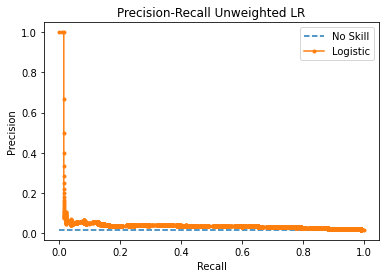

In [ ]:
#Get Precision-Recall curve unweighted model

# predict probabilities
lr_probs = clf_lr.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = clf_lr.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Precision-Recall Unweighted LR')

# show the legend
pyplot.legend()
# show the plot
pyplot.savefig(FOLDERNAME_AMY + '/precision_recall_curve_unweighted_lr_jun1.png', bbox_inches ='tight')
pyplot.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.721


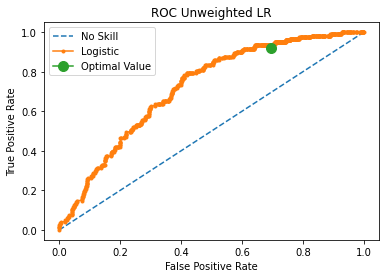

Testing False Positive Rate at Threshold: 0.607
Training False Positive Rate at Threshold: 0.672


In [38]:
#Get ROC (probably not so good since we have class imbalance) unweighted model

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = clf_lr.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Unweighted LR')
pyplot.plot(0.694, 0.92, marker="o", markersize=10, label = "Optimal Value")
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig(FOLDERNAME_AMY + '/ROC_unweighted_lr_jun1.png', bbox_inches ='tight')
pyplot.show()

# use evaluation metric
print("Testing ",end="")
eval_roc(lr_fpr,lr_tpr)
print("Training ",end="")
lr_probs = clf_lr.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
eval_roc(lr_fpr,lr_tpr)

## Weighted Logistic Regression
Weights are the inverse of label distribution as suggested by:
https://towardsdatascience.com/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68b

Can also try using grid search to find potentially more optimal weights (usually only minor improvement to ROC AUC score)


In [34]:
num_deaths = np.sum(y_train)
healthy_w = 1 / (len(y_train.index) - num_deaths)
death_w = 1 / num_deaths

class_weights = {0: healthy_w, 1: death_w}

clf_wlr = LogisticRegression(random_state=13, max_iter=5000, class_weight=class_weights).fit(X_train, y_train)
y_pred_wlr = clf_wlr.predict(X_test)

KeyboardInterrupt: ignored

In [ ]:
print("WEIGHTED LR PERFORMANCE: ")
print(f'Training Score: {clf_wlr.score(X_train, y_train)}')
print(f'Validation Score: {clf_wlr.score(X_test, y_test)}')
# [[TN, FP], 
#  [FN, TP]]
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_wlr)}')
print(f'Area Under Curve (ROC AUC Score): {roc_auc_score(y_test, y_pred_wlr)}')
print(f'Recall score: {recall_score(y_test, y_pred_wlr)}')
print(f'Precision score: {precision_score(y_test, y_pred_wlr)}')
print(f'F2 score: {fbeta_score(y_test, y_pred_wlr, beta=2)}')

# use evaluation metric
# predict probabilities
lr_probs = clf_wlr.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
print("Testing ",end="")
eval_roc(lr_fpr,lr_tpr)
print("Training ",end="")
lr_probs = clf_wlr.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
eval_roc(lr_fpr,lr_tpr)

#### Cross Validated Weighted LR with ROC scoring

In [ ]:
clf_wlrcv = LogisticRegressionCV(cv=5, random_state=13, max_iter=5000, class_weight=class_weights, scoring='roc_auc').fit(X_train, y_train)
y_pred_wlrcv = clf_wlrcv.predict(X_test)

In [ ]:
print("WEIGHTED LR WITH CV PERFORMANCE: ")
print(f'Training Score: {clf_wlrcv.score(X_train, y_train)}')
print(f'Validation Score: {clf_wlrcv.score(X_test, y_test)}')
# [[TN, FP], 
#  [FN, TP]]
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_wlrcv)}')
print(f'Area Under Curve (ROC AUC Score): {roc_auc_score(y_test, y_pred_wlrcv)}')
print(f'Recall score: {recall_score(y_test, y_pred_wlrcv)}')
print(f'Precision score: {precision_score(y_test, y_pred_wlrcv)}')
print(f'F2 score: {fbeta_score(y_test, y_pred_wlrcv, beta=2)}')

In [ ]:
#Get Precision-Recall curve weighted model

# predict probabilities
lr_probs = clf_wlrcv.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = clf_wlrcv.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Precision-Recall Weighted LR')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig(FOLDERNAME_AMY + '/precision_recall_curve_weighted_lr_jun1.png', bbox_inches ='tight')
pyplot.show()

In [ ]:
#Get ROC (probably not so good since we have class imbalance) weighted model

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = clf_wlrcv.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Weighted LR')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig(FOLDERNAME_AMY + '/ROC_weighted_lr_jun1.png', bbox_inches ='tight')
pyplot.show()

# use evaluation metric
print("Testing ",end="")
eval_roc(lr_fpr,lr_tpr)
print("Training ",end="")
lr_probs = clf_wlrcv.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
eval_roc(lr_fpr,lr_tpr)

#### Weighted LR with Grid Search for Weights (ROC Scoring)


In [ ]:
lr = LogisticRegression(random_state=13, max_iter=5000)
weights = np.linspace(0.90,0.99,20)
param_grid = {'class_weight': [{0:1.0-x, 1:x} for x in weights]}
# print(param_grid)

# define evaluation procedure
cv = StratifiedKFold(n_splits=5, random_state=1)
# define grid search
grid = GridSearchCV(estimator=lr, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc').fit(X_train, y_train)
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

In [ ]:
y_pred_wlrgs = grid.best_estimator_.predict(X_test)
print("WEIGHTED LR WITH GRID SEARCH PERFORMANCE: ")
print(f'Training Score: {grid.best_estimator_.score(X_train, y_train)}')
print(f'Validation Score: {grid.best_estimator_.score(X_test, y_test)}')
# [[TN, FP], 
#  [FN, TP]]
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_wlrgs)}')
print(f'Area Under Curve (ROC AUC Score): {roc_auc_score(y_test, y_pred_wlrgs)}')
print(f'Recall score: {recall_score(y_test, y_pred_wlrgs)}')
print(f'Precision score: {precision_score(y_test, y_pred_wlrgs)}')
print(f'F2 score: {fbeta_score(y_test, y_pred_wlrgs, beta=2)}')

From: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [ ]:
#Get Precision-Recall curve weighted model

# predict probabilities
lr_probs = grid.best_estimator_.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = grid.best_estimator_.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Precision-Recall Weighted LR')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig(FOLDERNAME_AMY + '/precision_recall_curve_weighted_lr_gridsearch_jun1.png', bbox_inches ='tight')
pyplot.show()

In [ ]:
#Get ROC (probably not so good since we have class imbalance) weighted model

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = grid.best_estimator_.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Weighted LR')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig(FOLDERNAME_AMY + '/ROC_weighted_lr_gridsearch_jun1.png', bbox_inches ='tight')
pyplot.show()

# use evaluation metric
print("Testing ",end="")
eval_roc(lr_fpr,lr_tpr)
print("Training ",end="")
lr_probs = grid.best_estimator_.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
eval_roc(lr_fpr,lr_tpr)

## Logistic Regression with CV on Oversampling of Dataset
Decided against undersampling (deleting majority class datapoints) just because we don't have that much data to begin with

Useful link: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

In [ ]:
# example of random oversampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler


# define oversampling strategy, makes minority class even with majority class, only done for training data
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)
# print(Counter(y_over), Counter(y_train))
clf_over = LogisticRegression(random_state=13, max_iter=5000).fit(X_over, y_over)
y_pred_over = clf_over.predict(X_test)

print("NORMAL (UNWEIGHTED) LR PERFORMANCE ON OVERSAMPLED TRAINING SET: ")
print(f'Training Score: {clf_over.score(X_over, y_over)}')
print(f'Validation Score: {clf_over.score(X_test, y_test)}')
# [[TN, FP], 
#  [FN, TP]]
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_over)}')
print(f'Area Under Curve (ROC AUC Score): {roc_auc_score(y_test, y_pred_over)}')
print(f'Recall score: {recall_score(y_test,y_pred_over)}')
print(f'Precision score: {precision_score(y_test,y_pred_over)}')
print(f'F2 score: {fbeta_score(y_test, y_pred_over, beta=2)}')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


NORMAL (UNWEIGHTED) LR PERFORMANCE ON OVERSAMPLED TRAINING SET: 
Training Score: 0.6703496843127732
Validation Score: 0.6297668858338314
Confusion Matrix: 
[[5172 3058]
 [  39   96]]
Area Under Curve (ROC AUC Score): 0.6697718374510597
Recall score: 0.7111111111111111
Precision score: 0.030437539632213063
F2 score: 0.12994044396318352


In [ ]:
#Get Precision-Recall curve weighted model

# predict probabilities
lr_probs = clf_over.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = clf_over.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Precision-Recall Weighted LR')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig(FOLDERNAME_AMY + '/precision_recall_curve_lr_oversampled_jun1.png', bbox_inches ='tight')
pyplot.show()

In [ ]:
#Get ROC (probably not so good since we have class imbalance) weighted model

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = clf_over.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Weighted LR')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig(FOLDERNAME_AMY + '/ROC_lr_oversampled_jun1.png', bbox_inches ='tight')
pyplot.show()

# use evaluation metric
print("Testing ",end="")
eval_roc(lr_fpr,lr_tpr)
print("Training ",end="")
lr_probs = clf_over.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
eval_roc(lr_fpr,lr_tpr)

In [ ]:
clf_overcv = LogisticRegressionCV(cv=5, random_state=13, max_iter=5000, scoring='roc_auc').fit(X_over, y_over)
y_pred_overcv = clf_overcv.predict(X_test)
print("NORMAL (UNWEIGHTED) LR PERFORMANCE WITH CV ON OVERSAMPLED TRAINING SET: ")
print(f'Training Score: {clf_overcv.score(X_over, y_over)}')
print(f'Validation Score: {clf_overcv.score(X_test, y_test)}')
# [[TN, FP], 
#  [FN, TP]]
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_overcv)}')
print(f'Area Under Curve (ROC AUC Score): {roc_auc_score(y_test, y_pred_overcv)}')
print(f'Recall score: {recall_score(y_test,y_pred_overcv)}')
print(f'Precision score: {precision_score(y_test,y_pred_overcv)}')
print(f'F2 score: {fbeta_score(y_test, y_pred_overcv, beta=2)}')

# use evaluation metric
print("Testing ",end="")
lr_probs = clf_overcv.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
eval_roc(lr_fpr,lr_tpr)
print("Training ",end="")
lr_probs = clf_overcv.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
eval_roc(lr_fpr,lr_tpr)

## Combo oversampling and undersampling (supposed to reduce overfitting)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.1)
# fit and apply the transform
X_over2, y_over2 = over.fit_resample(X_train, y_train)
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
X_combined, y_combined = under.fit_resample(X_over2, y_over2)

clf_combo = LogisticRegressionCV(cv=5, random_state=13, max_iter=5000, scoring='roc_auc').fit(X_combined, y_combined)
y_pred_combo = clf_combo.predict(X_test)

print("NORMAL (UNWEIGHTED) LR PERFORMANCE ON OVERSAMPLED & UNDERSAMPLED TRAINING SET: ")
print(f'Training Score: {clf_combo.score(X_combined, y_combined)}')
print(f'Validation Score: {clf_combo.score(X_test, y_test)}')
# [[TN, FP], 
#  [FN, TP]]
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_combo)}')
print(f'Area Under Curve (ROC AUC Score): {roc_auc_score(y_test, y_pred_combo)}')
print(f'Recall score: {recall_score(y_test,y_pred_combo)}')
print(f'Precision score: {precision_score(y_test,y_pred_combo)}')
print(f'F2 score: {fbeta_score(y_test, y_pred_combo, beta=2)}')

In [ ]:
#Get Precision-Recall curve weighted model

# predict probabilities
lr_probs = clf_combo.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = clf_combo.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Precision-Recall Weighted LR')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig(FOLDERNAME_AMY + '/precision_recall_curve_lr_combosample_jun1.png', bbox_inches ='tight')
pyplot.show()

In [ ]:
#Get ROC (probably not so good since we have class imbalance) weighted model

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = clf_combo.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Weighted LR')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig(FOLDERNAME_AMY + '/ROC_lr_combosample_jun1.png', bbox_inches ='tight')
pyplot.show()

# use evaluation metric
print("Testing ",end="")
eval_roc(lr_fpr,lr_tpr)
print("Training ",end="")
lr_probs = clf_combo.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
eval_roc(lr_fpr,lr_tpr)

## LR on SMOTE and Borderline-SMOTE Data
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

#BORDERLINE
oversample = BorderlineSMOTE()
X_SMOTE, y_SMOTE = oversample.fit_resample(X_train, y_train)
counter = Counter(y_SMOTE)
print(counter)

clf_SMOTE = LogisticRegressionCV(cv=5, random_state=13, max_iter=5000, scoring='roc_auc').fit(X_SMOTE, y_SMOTE)
y_pred_SMOTE = clf_SMOTE.predict(X_test)

print("NORMAL (UNWEIGHTED) LR PERFORMANCE ON BORDERLINE SMOTE TRAINING SET: ")
print(f'Training Score: {clf_SMOTE.score(X_SMOTE, y_SMOTE)}')
print(f'Validation Score: {clf_SMOTE.score(X_test, y_test)}')
# [[TN, FP], 
#  [FN, TP]]
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_SMOTE)}')
print(f'Area Under Curve (ROC AUC Score): {roc_auc_score(y_test, y_pred_SMOTE)}')
print(f'Recall score: {recall_score(y_test,y_pred_SMOTE)}')
print(f'Precision score: {precision_score(y_test,y_pred_SMOTE)}')
print(f'F2 score: {fbeta_score(y_test, y_pred_SMOTE, beta=2)}')

In [ ]:
# use evaluation metric
print("Testing ",end="")
lr_probs = clf_SMOTE.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
eval_roc(lr_fpr,lr_tpr)
print("Training ",end="")
lr_probs = clf_SMOTE.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
eval_roc(lr_fpr,lr_tpr)

In [ ]:
# NORMAL
from imblearn.over_sampling import SMOTE
oversample_normal = SMOTE()
X_normal, y_normal = oversample_normal.fit_resample(X_train, y_train)
counter = Counter(y_normal)
print(counter)
clf_n = LogisticRegressionCV(cv=5, random_state=13, max_iter=5000, scoring='roc_auc').fit(X_normal, y_normal)
y_pred_n = clf_n.predict(X_test)

print("NORMAL (UNWEIGHTED) LR PERFORMANCE ON NORMAL SMOTE TRAINING SET: ")
print(f'Training Score: {clf_n.score(X_normal, y_normal)}')
print(f'Validation Score: {clf_n.score(X_test, y_test)}')
# [[TN, FP], 
#  [FN, TP]]
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_n)}')
print(f'Area Under Curve (ROC AUC Score): {roc_auc_score(y_test, y_pred_n)}')
print(f'Recall score: {recall_score(y_test,y_pred_n)}')
print(f'Precision score: {precision_score(y_test,y_pred_n)}')
print(f'F2 score: {fbeta_score(y_test, y_pred_n, beta=2)}')

In [ ]:
#Get Precision-Recall curve weighted model

# predict probabilities
lr_probs = clf_n.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = clf_n.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Precision-Recall Weighted LR')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig(FOLDERNAME_AMY + '/precision_recall_curve_lr_SMOTE_jun1.png', bbox_inches ='tight')
pyplot.show()

In [ ]:
#Get ROC (probably not so good since we have class imbalance) weighted model

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = clf_n.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Weighted LR')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig(FOLDERNAME_AMY + '/ROC_lr_SMOTE_jun1.png', bbox_inches ='tight')
pyplot.show()

# use evaluation metric
print("Testing ",end="")
eval_roc(lr_fpr,lr_tpr)
print("Training ",end="")
lr_probs = clf_n.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
eval_roc(lr_fpr,lr_tpr)

## Cost Sensitive SVM
https://machinelearningmastery.com/cost-sensitive-svm-for-imbalanced-classification/ 


In [ ]:
from sklearn.svm import SVC
SVM = SVC(gamma='scale', class_weight='balanced').fit(X_over, y_over)
y_pred_SVM = SVM.predict(X_test)

print("SVM PERFORMANCE ON RANDOMLY OVERSAMPLED TRAINING SET: ")
print(f'Training Score: {SVM.score(X_over, y_over)}')
print(f'Validation Score: {SVM.score(X_test, y_test)}')
# [[TN, FP], 
#  [FN, TP]]
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_SVM)}')
print(f'Area Under Curve (ROC AUC Score): {roc_auc_score(y_test, y_pred_SVM)}')
print(f'Recall score: {recall_score(y_test,y_pred_SVM)}')
print(f'Precision score: {precision_score(y_test,y_pred_SVM)}')
print(f'F2 score: {fbeta_score(y_test, y_pred_SVM, beta=2)}')

In [ ]:
# use evaluation metric
print("Testing ",end="")
lr_probs = SVM.decision_function(X_test)
# keep probabilities for the positive outcome only
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
eval_roc(lr_fpr,lr_tpr)
print("Training ",end="")
lr_probs = SVM.decision_function(X_train)
# keep probabilities for the positive outcome only
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
eval_roc(lr_fpr,lr_tpr)

## XGBoost, Tuned

In [ ]:
neg = np.sum(labels == 0)
pos = np.sum(labels > 0)
weight = neg/pos
weight_sqrt = np.sqrt(neg/pos) 
print("Num Neg = ", neg)
print("Num Pos = ", pos)
print("Current Weighting Scheme = ", weight)
# see (https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets)

Num Neg =  41174
Num Pos =  647
Current Weighting Scheme =  63.63833075734158


In [ ]:
# # define model as a classifier with scaled weighting for positive classes (bc of class imbalance)
# clf_xgb_weighted = XGBClassifier(scale_pos_weight=99) 
# # define evaluation procedure
# cv_xgb_weighted = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
# # evaluate model
# scores_weighted = cross_val_score(clf_xgb_weighted, X_train, y_train, scoring='balanced_accuracy', cv=cv_xgb_weighted, n_jobs=-1) #score with balanced accuracy (see: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [ ]:
clf_xgb = XGBClassifier() 
clf_xgb.fit(X_train, y_train)
# make predictions for test data
# y_pred2 = clf_xgb_weighted.predict(X_test)
y_preds2 = clf_xgb.predict(X_test)
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_preds2)}')
print(f'Area Under Curve (ROC AUC Score): {roc_auc_score(y_test, y_preds2)}')
print(f'Recall score: {recall_score(y_test, y_preds2)}')
print(f'Precision score: {precision_score(y_test, y_preds2)}')
print(f'F2 score: {fbeta_score(y_test, y_preds2, beta=2)}')

print("\nTraining")
y_preds2 = clf_xgb.predict_proba(X_train)[:, 1]
xgb_fpr, xgb_tpr, xgb_thresh = roc_curve(y_train, y_preds2)
eval_roc(xgb_fpr,xgb_tpr) #prints, Cora's function

print("\nTesting")
y_preds2 = tuned_xgb.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, xgb_thresh = roc_curve(y_test, y_preds2)
eval_roc(xgb_fpr,xgb_tpr) #prints, Cora's function

Confusion Matrix: 
[[8231    0]
 [ 134    0]]
Area Under Curve (ROC AUC Score): 0.5
Recall score: 0.0
Precision score: 0.0
F2 score: 0.0

Training
False Positive Rate at Threshold: 0.551

Testing
False Positive Rate at Threshold: 0.676


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
# # summarize performance
# print('Mean Recall: %.5f' % np.mean(scores_weighted)) #Recall = TP / (TP + FN) #Balanced Accuracy 
# print(scores_weighted)

Mean Recall: 0.63372
[0.65728481 0.60784176 0.63932091 0.67596095 0.62292163 0.64886351
 0.63155528 0.65402427 0.59739482 0.60199958]


In [ ]:
clf_xgb = XGBClassifier()
# define evaluation procedure
cv = StratifiedKFold(n_splits=5)
params = {
        'scale_pos_weight': [0, 63, 99, 150],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 5, 7, 10, 15, 25],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500, 750, 1000],
        'gamma' : [ 0.0, 0.05, 0.15, 0.3]
    }
random_search= RandomizedSearchCV(estimator = clf_xgb,param_distributions=params,n_iter=50,scoring="roc_auc",n_jobs=-1,cv=cv, verbose = 3) #tune here, change n_iter to higher if we want to search over greater search space
random_search.fit(X_train,y_train)
print(random_search.best_estimator_)
print(random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 42.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 86.7min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.15,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=150, seed=None,
              silent=None, subsample=0.7, verbosity=1)
{'subsample': 0.7, 'scale_pos_weight': 150, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.15, 'colsample_bytree': 0.5}


In [13]:
tuned_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=100,
              learning_rate=0.001, max_delta_step=0, max_depth=5,
              min_child_weight=50, missing=None, n_estimators=185, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=35, reg_lambda=45, scale_pos_weight=150, seed=None,
              silent=None, subsample=0.7, verbosity=1) #manually tuned after random search for regularization (lambda, alpha, reduced n_estimators)
tuned_xgb.fit(X_train, y_train)
y_preds = tuned_xgb.predict(X_test)
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_preds)}')
print(f'Area Under Curve (ROC AUC Score): {roc_auc_score(y_test, y_preds)}')
print(f'Recall score: {recall_score(y_test, y_preds)}')
print(f'Precision score: {precision_score(y_test, y_preds)}')
print(f'F2 score: {fbeta_score(y_test, y_preds, beta=2)}')

print("\nTraining")
y_preds = tuned_xgb.predict_proba(X_train)[:, 1]
xgb_fpr, xgb_tpr, xgb_thresh = roc_curve(y_train, y_preds)
eval_roc(xgb_fpr,xgb_tpr) #prints, Cora's function

print("\nTesting")
y_preds = tuned_xgb.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, xgb_thresh = roc_curve(y_test, y_preds)
eval_roc(xgb_fpr,xgb_tpr) #prints, Cora's function

Confusion Matrix: 
[[2130 6114]
 [   8  113]]
Area Under Curve (ROC AUC Score): 0.5961270104779434
Recall score: 0.9338842975206612
Precision score: 0.018146780150955517
F2 score: 0.0841901355982715

Training
False Positive Rate at Threshold: 0.614

Testing
False Positive Rate at Threshold: 0.677


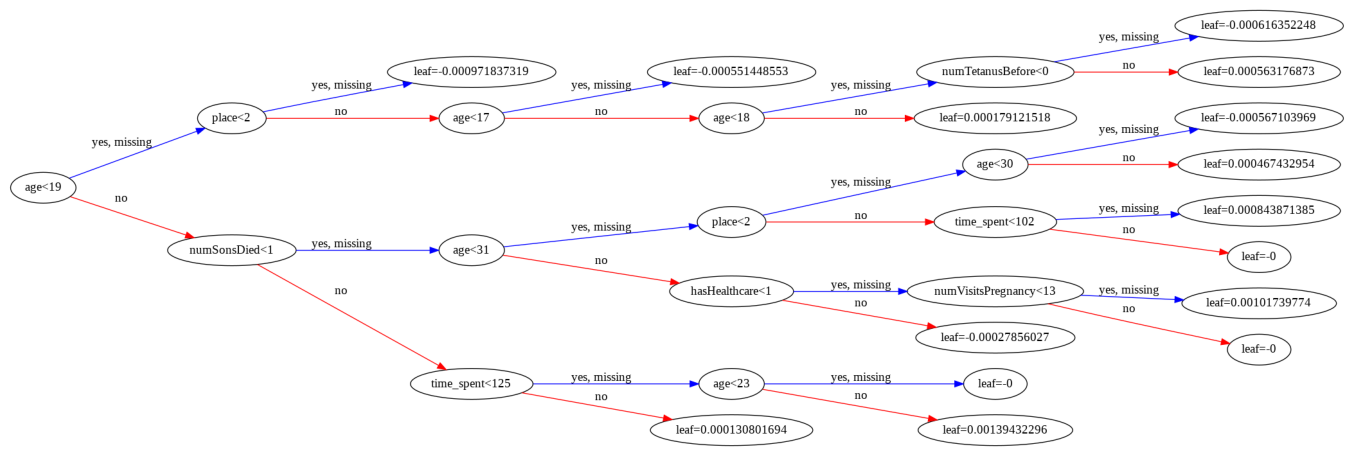

In [22]:
xgboost.plot_tree(tuned_xgb, rankdir='LR')
fig = pyplot.gcf()
fig.set_size_inches(24, 24)
pyplot.savefig(FOLDERNAME_AMY + '/decision_tree_jun2.png', bbox_inches ='tight')
pyplot.show()

In [25]:
!pip install shap
import shap 
data = shuff.iloc[:,:-1]
labels = (shuff["numMaternalDeaths"] > 0).astype(int)
designMatrix = xgboost.DMatrix(X_test, y_test)
explainer = shap.TreeExplainer(tuned_xgb)
shap_values = explainer.shap_values(designMatrix)

     |████████████████████████████████| 358kB 7.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491624 sha256=73ad5bda22c20cd42757951a84b8d8f8abc0488cfd1c3dee8c8f7afd3027b35d
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


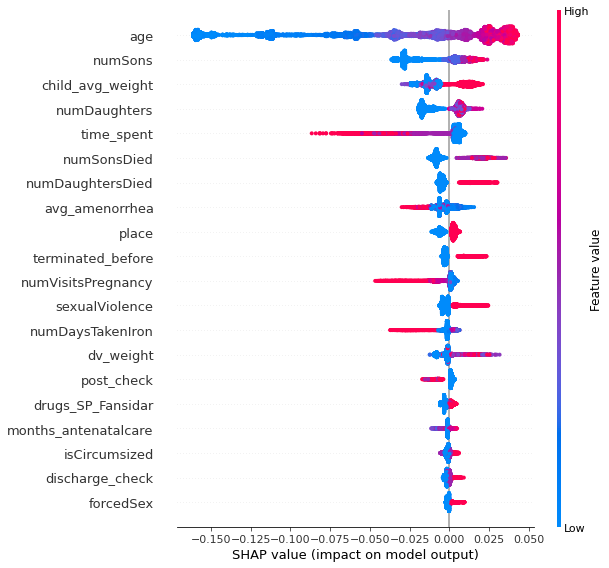

In [ ]:
shap.summary_plot(shap_values, X_test, show=False)
pyplot.savefig(FOLDERNAME_AMY + '/SHAPXGB_tuned_jun1.png', bbox_inches ='tight')

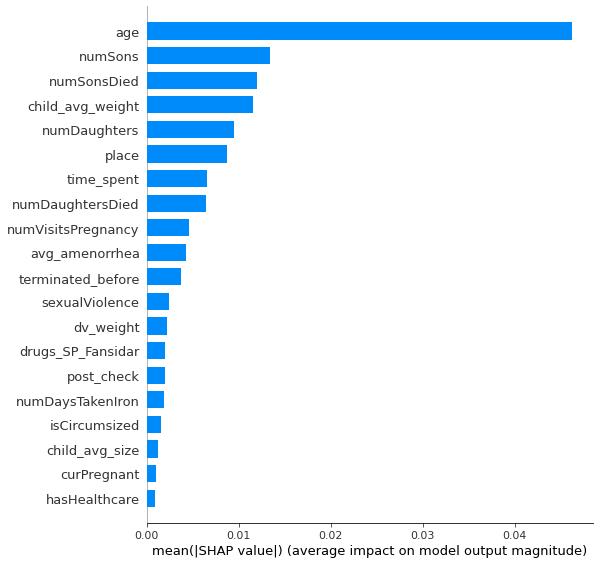

In [26]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show = False)
pyplot.savefig(FOLDERNAME_AMY + '/SHAPXGB_tuned_feature_importance_jun1.png', bbox_inches ='tight')

In [31]:
sum(y_train)

526

In [32]:
sum(y_test)

121

In [1]:

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_train))]

# predict probabilities
xgb_probs = tuned_xgb.predict_proba(X_train)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_train, ns_probs)
xgb_auc = roc_auc_score(y_train, xgb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_train, xgb_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(xgb_fpr, xgb_tpr, linestyle='-', label='XGBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# pyplot.plot(0.861, 0.92, 'rx', label = "Optimal Value")
pyplot.title('ROC Tuned XGBoost Training Data')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig(FOLDERNAME_AMY + '/ROC_xgb_tuned_training_data_jun1.png', bbox_inches ='tight')
pyplot.show()

NameError: ignored

No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.718


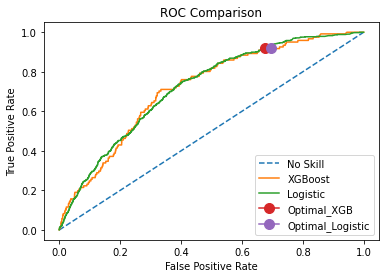

In [42]:

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
xgb_probs = tuned_xgb.predict_proba(X_test)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(xgb_fpr, xgb_tpr, linestyle='-', label='XGBoost')
pyplot.plot(lr_fpr, lr_tpr, linestyle='-', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.plot(0.676, 0.92, marker="o", markersize=10, label = "Optimal_XGB")
pyplot.plot(0.694, 0.92, marker="o", markersize=10, label = "Optimal_Logistic")
pyplot.title('ROC Comparison')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig(FOLDERNAME_AMY + '/ROC_xgb_tuned_jun1.png', bbox_inches ='tight')
pyplot.show()

## Error Analysis XGB




## Mapping Results to Regions

In [ ]:
def region_map(regions, predictions, title):
  num_regions = np.max(regions)
  num_pos = np.zeros(num_regions)
  objects = []
  y_pos = np.arange(num_regions)+1
  for i in range(num_regions):
    num_pos[i] = np.sum(predictions[regions==i])/max(1,np.sum(regions==i))
    objects.append("region "+str(i+1))
  y_pos = np.arange(num_regions)

  plt.bar(y_pos, num_pos, align='center', alpha=0.5)
  plt.xticks(y_pos, objects)
  plt.ylabel('Fraction of Region Predicted Positive')
  plt.title(title + ': Stratification of Predicted Positive cases')

  #plt.show()
  pyplot.savefig(FOLDERNAME_AMY + '/baseline_regions.png', bbox_inches ='tight')

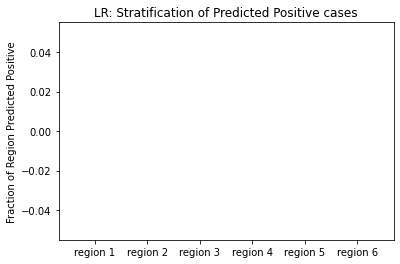

In [ ]:
# To generate a region graph for a classifier run a line of the form: 
#   region_map(regions,"the classifier's predictions on rem.iloc[:,:-1]", name of your classifier)

region_map(regions,clf_lr.predict(rem.iloc[:,:-1]), "LR")  # normal LR
#region_map(regions,clf_wlr.predict(rem.iloc[:,:-1]), "WLR") # weighted LR
#region_map(regions,clf_wlrcv.predict(rem.iloc[:,:-1]), "WLRCV") # weighted LR with CV
#region_map(regions,grid.best_estimator_.predict(rem.iloc[:,:-1]), "Grid") # LR grid to estimate weights
#region_map(regions,clf_over.predict(rem.iloc[:,:-1]), "LR Over") # oversampling LR
#region_map(regions,clf_overcv.predict(rem.iloc[:,:-1]), "LR Over CV") # oversampling LR with CV
#region_map(regions,clf_combo.predict(rem.iloc[:,:-1]), "LR Combo") # combo LR
#region_map(regions,tuned_xgb.predict(rem.iloc[:,:-1]), "XGBoost Tuned") # XGBoost
#pyplot.savefig(FOLDERNAME_AMY + '/xgb_regions.png', bbox_inches ='tight')

# still need to add XG boost once Sameer is done

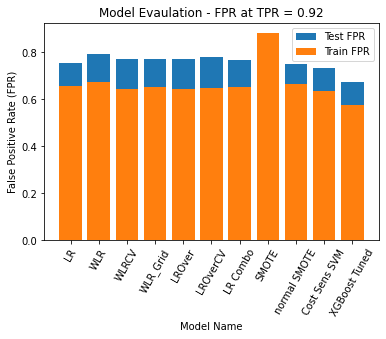

In [ ]:
model_performance = pd.read_csv(FOLDERNAME + "/model_performance_threshold.csv")
model_performance.head()
pyplot.bar(model_performance['Model Name'], model_performance['Test FPR'], label = "Test FPR")
pyplot.bar(model_performance['Model Name'], model_performance['Train FPR'], label = "Train FPR")
pyplot.xlabel('Model Name')
pyplot.xticks(rotation = 60) 
pyplot.ylabel('False Positive Rate (FPR)')
pyplot.title('Model Evaulation - FPR at TPR = 0.92')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig(FOLDERNAME_AMY + '/model_evaluation.png', bbox_inches ='tight')
pyplot.show()